# 🧑‍🎓 Students:

- Diyun LU
- Marwan MASHRA
- Yihan ZHONG

# Out of domain and cross-lingual part-of-speech tagging

The goal of this lab exercise is to build a part-of-speech tagger that should be tested in the two following settings:
- out-of-domain generalization: test the tagger on a different domain than the one used for training (but in the same language).
- cross-lingual generalization: test the tagger on a different language that has been used for training.

To this end, you will rely on the aligned fast-text embeddings: https://fasttext.cc/docs/en/aligned-vectors.html
However, the original files are quite big, so I uploaded on the website a filtered version of them that contains only words data appears in the data we use.
Two important points:
- you must not fine tune these embeddings, they are fixed
- you need to have a special embedding for unknown words (the ones that don't have embeddings in fasttext) that you initialize and fix to a vector full of 0 (e.g. add an unk word to your dictionnary)
To take care of this, the best way is to build the dictionnary when you read the fasttext embedding file, and then when you read the data, replace the words that don't have embeddings with the UNK word.

**Warning:** do not use any external library or tools to load the fast text embeddings. Do it yourself, it is just a few lines of Python.

## Reading data

The data is in the conllu format: https://universaldependencies.org/format.html

Basically:
- comments are lines starting with a #
- a blank line separate sentences
- the ID column can contain 3 types of values:
  - a single number
  - a "empty" token, these IDs contains a ".", for example 4.1 --- ignore these lines
  - multiwords, these IDs contains a "-", for example 4-5 --- ignore these lines
- you must convert all word to lowercase (we only have embeddings for lowercased words)

You must start by writting a function that reads a conllu files and returns the list of sentences and the list of part-of-speech tags (i.e. keep only columns "form" and "UPOS").

**Warning:** do not use any library to read these files, it is just a few lines of Python.

Dataset files:
- in domain english data: en_ewt-ud-*.conllu
- out of domain english data: en_pud-ud-test.conllu
- French test data: fr_gsd-ud-test.conllu

## Neural network

You must build a very simple neural network:
- word embeddings from fast-text
- a bilstm to construct context sensitive representations of words
- to predict the POS of each word, use a very simple and shallow MLP (even a simple linear projection is sufficient) at each position

Importantly, word embeddings will be different when you test in the cross-lingual settings. Therefore, I strongly recommend you to have two separate modules:
- one that retrieves word embeddings, that you instantiate two times (one time with English embeddings, one time with French embeddings) --- this also means that you need two dictionnaries that maps words to integers
- one that does the rest of the computation

In order to correctly batch you data during training, you will need to use pack_padded_sequence and pad_packed_sequence (check the lecture slides). Explain in the report why you needs them in this case (and why you didn't need them in the language model lab exercise) and what they do.

## Evaluation:

Returns the tagging accuracy, i.e. the number of correctly predicted tags.

If you have time, you can also explore more fine-grained metrics, especially in the cross-lingual case: accuracy per tag type, recall/precision/F1 per tag type, ...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random, os, math
import matplotlib.pyplot as plt 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read embeddings

In [2]:
data_path = "data_pos/"
fr_emb_path = data_path+"fasttext_fr"
en_emb_path = data_path+"fasttext_en"

fr_vocab = {}
en_vocab = {}

emb_dim = 300

def read_emb(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        emb = torch.empty(size=(len(lines)+1, emb_dim))
        word_to_id = {}
        id_to_word = {}
        i = len(lines)
        word_to_id['<unk>'] = i
        id_to_word[i] = '<unk>'
        emb[i].zero_() 
        for i, line in enumerate(lines):
            splitted_lines = line.split()
            word = splitted_lines[0]
            word_to_id[word] = i
            id_to_word[i] = word
            emb[i] = torch.tensor(list(map(float, splitted_lines[-emb_dim:])), requires_grad=False)    # mistake line 13334
        return emb, word_to_id, id_to_word

en_emb, en_word_to_id, en_id_to_word = read_emb(en_emb_path)
fr_emb, fr_word_to_id, fr_id_to_word = read_emb(fr_emb_path)

### Read Data

In [3]:
def read_conll(in_file, lowercase=True, max_example=None):
    list_txt = []
    list_pos = []
    with open(in_file) as f:
        word, pos = [], []
        for line in f.readlines():
            sp = line.strip().split('\t')
            if len(sp) == 10:
                if sp[0].isdigit():
                    word.append(sp[1].lower() if lowercase else sp[1])
                    pos.append(sp[3])
            elif len(word) > 0:
                list_txt.append(word)
                list_pos.append(pos)
                word, pos = [], []
                if (max_example is not None) and (len(list_txt) == max_example):
                    break
        if len(word) > 0:
            list_txt.append(word)
            list_pos.append(pos)
    return list_txt, list_pos

en_txt_train, en_pos_train = read_conll(data_path+"en_ewt-ud-train.conllu")
en_txt_dev, en_pos_dev = read_conll(data_path+"en_ewt-ud-dev.conllu")
en_txt_test, en_pos_test = read_conll(data_path+"en_ewt-ud-test.conllu")

fr_txt_test, fr_pos_test = read_conll(data_path+"fr_gsd-ud-test.conllu")
pud_txt_test, pud_pos_test = read_conll(data_path+"en_pud-ud-test.conllu")

### Process Data

In [ ]:
def get_pos_idx(pos):
    pos_to_id = {}
    id_to_pos = {}
    for sentence in pos:
        for p in sentence:
            if p not in pos_to_id:
                index = len(pos_to_id)
                pos_to_id[p] = index
                id_to_pos[index] = p
    return pos_to_id, id_to_pos

en_pos_to_id, en_id_to_pos = get_pos_idx(en_pos_train)
en_pos_to_id

{'PROPN': 0,
 'PUNCT': 1,
 'ADJ': 2,
 'NOUN': 3,
 'VERB': 4,
 'DET': 5,
 'ADP': 6,
 'AUX': 7,
 'PRON': 8,
 'PART': 9,
 'SCONJ': 10,
 'NUM': 11,
 'ADV': 12,
 'CCONJ': 13,
 'X': 14,
 'INTJ': 15,
 'SYM': 16}

In [5]:
def encoder(txt, pos, word_to_id, pos_to_id):
    def word_encoder(word):
        if word not in word_to_id and word[-1]=='s' and word[:-1] in word_to_id:
            word = word[:-1]
        elif word not in word_to_id:
            word = '<unk>'
        return word_to_id[word]

    sentence_encoder = lambda sentence: list(map(word_encoder, sentence))
    pos_encoder = lambda sentence: list(map(lambda p: pos_to_id[p], sentence))

    txt_encoded = list(map(sentence_encoder, txt))
    pos_encoded = list(map(pos_encoder, pos))

    return txt_encoded, pos_encoded

en_x_train, en_y_train = encoder(en_txt_train, en_pos_train, en_word_to_id, en_pos_to_id)
en_x_dev, en_y_dev = encoder(en_txt_dev, en_pos_dev, en_word_to_id, en_pos_to_id)
en_x_test, en_y_test = encoder(en_txt_test, en_pos_test, en_word_to_id, en_pos_to_id)

fr_x_test, fr_y_test = encoder(fr_txt_test, fr_pos_test, fr_word_to_id, en_pos_to_id)
pud_x_test, pud_y_test = encoder(pud_txt_test, pud_pos_test, en_word_to_id, en_pos_to_id)

### Create Embeddings table

In [6]:
class Embedding(nn.Module):
    def __init__(self, emb_table: torch.Tensor):
        super(Embedding, self).__init__()
        self.emb_table = emb_table

    def forward(self, input):
        emb = list()
        for sentence in input:
            emb.append(self.emb_table[sentence].to(device))
        return emb

en_emb_table = Embedding(en_emb)
fr_emb_table = Embedding(fr_emb)
emb_example = en_emb_table(en_x_train[:10])
[emb.shape for emb in emb_example]

[torch.Size([29, 300]),
 torch.Size([18, 300]),
 torch.Size([17, 300]),
 torch.Size([16, 300]),
 torch.Size([36, 300]),
 torch.Size([13, 300]),
 torch.Size([13, 300]),
 torch.Size([16, 300]),
 torch.Size([35, 300]),
 torch.Size([20, 300])]

### Create the Tagger

In [102]:
class Tagger(nn.Module):
    def __init__(self, output_dim, stack_size=2, embedding_dim=300, hidden_dim=10, hidden_size=10, num_layers=1, dropout=0.0):
        super(Tagger, self).__init__()
        assert stack_size > 0
        self.output_dim = output_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.hidden_size = hidden_size
        self.lstms = nn.ModuleList(
            nn.LSTM(input_size=self.hidden_size*2, hidden_size=self.hidden_size,
                        num_layers=num_layers, batch_first=True, bidirectional=True).to(device)
            for _ in range(stack_size-1)
        )
        self.lstms.insert(0, nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size,
                        num_layers=num_layers, batch_first=True, bidirectional=True).to(device))

        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_size*2, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
        ).to(device)

    def forward(self, emb):
        # pad the sequence
        lengths = list(map(len, emb))
        padded_emb = pad_sequence(emb, batch_first=True)
        packed_emb = pack_padded_sequence(padded_emb, batch_first=True, lengths=lengths, enforce_sorted=False)
        # forward through LSTMs
        packed_output = packed_emb
        for lstm in self.lstms:
            packed_output, _ = lstm(packed_output)
        unpacked_output, unpacked_lengths = pad_packed_sequence(packed_output, batch_first=True)
        stacked_output = unpacked_output.view(-1, unpacked_output.size(2))
        # create the mask
        mask = torch.zeros(size=unpacked_output.shape[:2]).to(device)
        for i, length in enumerate(unpacked_lengths):
            mask[i, :length] = 1
        mask = mask.view(-1).to(bool)
        # forward through MLP
        output = stacked_output[mask]
        logits = self.mlp(output)
        log_probs = F.log_softmax(logits, dim=1)
        return log_probs

    def predict(self, emb, batch_size=256):
        self.eval()
        y_pred = []
        for i in range(0, len(emb), batch_size):  
            emb_batch = emb[i:i+batch_size]
            log_probs = self.forward(emb_batch)
            y_pred.append(log_probs.argmax(dim=1))
        return torch.cat(y_pred)

    def compute_accuracy(self, emb, y_gold, batch_size=256):
        self.eval()
        gold_batch = torch.cat([torch.tensor(y) for y in y_gold]).to(device)
        y_pred = self.predict(emb, batch_size=batch_size)
        acc = (gold_batch==y_pred).sum() / y_pred.size(0)    
        return acc.item()
        

tagger = Tagger(output_dim=len(en_pos_to_id)).to(device)
print(tagger.compute_accuracy(en_emb_table(en_x_train[:10]), en_y_train[:10]))
tagger.predict(emb_example)

0.10798121988773346


tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')

### Training Loop

In [35]:
def train(
    model,
    n_epoch=100,
    batch_size=256,
    lr=1e-3,
    early_stopping=True,
    early_stopping_limit=3,
    save_plot=False,
    emb_table=en_emb_table,
    x_train=en_x_train,
    y_train=en_y_train,
    x_dev=en_x_dev,
    y_dev=en_y_dev,
    x_test=en_x_test,
    y_test=en_y_test,
):

    early_stopping_limit = early_stopping_limit
    dev_loss_up = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_train = list()
    loss_dev = list()
    loss_function = nn.NLLLoss()
    acc_train = list()
    acc_dev = list()
    for epoch in range(n_epoch):
        model.train()
        losses_train = list()
        batch_counter = 0
        for i in range(0, len(x_train), batch_size):
            optimizer.zero_grad()
            gold = torch.cat([torch.tensor(y) for y in y_train[i:i+batch_size]]).to(device)
            batch = x_train[i:i+batch_size]
            emb_batch = emb_table(batch)
            log_probs = model(emb_batch)
            loss = loss_function(log_probs, gold)
            losses_train.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            print(f"batch {batch_counter}/{int(len(x_train)/batch_size)}", end='\r', flush=True)
            batch_counter += 1
        mean_train_loss = sum(losses_train)/len(losses_train)
        loss_train.append(mean_train_loss)
        losses_dev = []

        model.eval()
        log_probs = model(emb_table(x_dev))
        dev_labels = torch.cat([torch.tensor(y) for y in y_dev]).to(device)
        dev_loss = loss_function(log_probs, dev_labels) 
        loss_dev.append(dev_loss.item())

        acc_train.append(model.compute_accuracy(emb_table(x_train), y_train))
        acc_dev.append(model.compute_accuracy(emb_table(x_dev), y_dev))

        print(f"{epoch+1}) train_loss: {mean_train_loss:.3f}  dev_loss: {loss_dev[-1]:.3f} train_acc:{acc_train[-1]:.3f} dev_acc:{acc_dev[-1]:.3f}")

        if early_stopping: 
            if len(loss_dev)>5 and loss_dev[-1]>=loss_dev[-2]:
                dev_loss_up += 1
            else:
                dev_loss_up = 0
            if dev_loss_up==early_stopping_limit:
                print(f"Preformed {epoch+1} epochs")
                break

    return loss_train, loss_dev, acc_train, acc_dev

### Two Stack BiLSTM Tagger

In [36]:
tagger = Tagger(output_dim=len(en_pos_to_id)).to(device)
loss_train, loss_dev, acc_train, acc_dev = train(tagger)

1) train_loss: 2.812  dev_loss: 2.736 train_acc:0.080 dev_acc:0.076
2) train_loss: 2.652  dev_loss: 2.556 train_acc:0.141 dev_acc:0.151
3) train_loss: 2.473  dev_loss: 2.376 train_acc:0.252 dev_acc:0.258
4) train_loss: 2.279  dev_loss: 2.177 train_acc:0.287 dev_acc:0.290
5) train_loss: 2.091  dev_loss: 2.007 train_acc:0.358 dev_acc:0.353
6) train_loss: 1.932  dev_loss: 1.856 train_acc:0.406 dev_acc:0.398
7) train_loss: 1.777  dev_loss: 1.699 train_acc:0.454 dev_acc:0.443
8) train_loss: 1.607  dev_loss: 1.526 train_acc:0.503 dev_acc:0.492
9) train_loss: 1.418  dev_loss: 1.341 train_acc:0.558 dev_acc:0.546
10) train_loss: 1.241  dev_loss: 1.176 train_acc:0.654 dev_acc:0.637
11) train_loss: 1.072  dev_loss: 1.025 train_acc:0.706 dev_acc:0.688
12) train_loss: 0.938  dev_loss: 0.923 train_acc:0.738 dev_acc:0.722
13) train_loss: 0.850  dev_loss: 0.851 train_acc:0.760 dev_acc:0.745
14) train_loss: 0.784  dev_loss: 0.792 train_acc:0.781 dev_acc:0.767
15) train_loss: 0.729  dev_loss: 0.741 trai

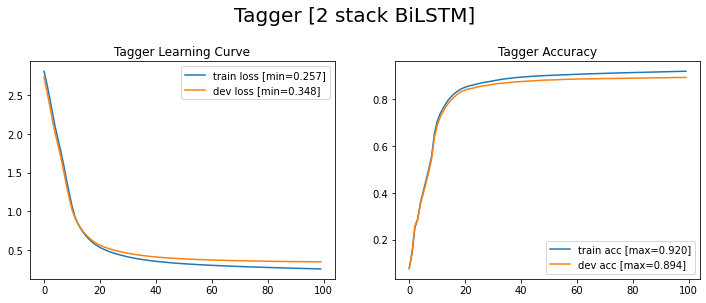

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].plot(torch.arange(len(loss_train)), loss_train, label=f"train loss [min={min(loss_train):.3f}]")
axes[0].plot(torch.arange(len(loss_dev)), loss_dev, label=f"dev loss [min={min(loss_dev):.3f}]")
axes[0].legend()
axes[0].set_title("Tagger Learning Curve")

axes[1].plot(torch.arange(len(acc_train)), acc_train, label=f"train acc [max={max(acc_train):.3f}]")
axes[1].plot(torch.arange(len(acc_dev)), acc_dev, label=f"dev acc [max={max(acc_dev):.3f}]")
axes[1].legend()
axes[1].set_title("Tagger Accuracy")

fig.suptitle(f"Tagger [{len(tagger.lstms)} stack BiLSTM]", fontsize=20, y=1.07)

plt.show()

In [38]:
acc_test = tagger.compute_accuracy(en_emb_table(en_x_test), en_y_test)
acc_test_pud = tagger.compute_accuracy(en_emb_table(pud_x_test), pud_y_test)
acc_test_fr = tagger.compute_accuracy(fr_emb_table(fr_x_test), fr_y_test)

print(f'Accuracy on the english test set = {acc_test:.3f}')
print(f'Accuracy on the english out of domain data = {acc_test_pud:.3f}')
print(f'Accuracy on the french data = {acc_test_fr:.3f}')

Accuracy on the english test set = 0.901
Accuracy on the english out of domain data = 0.897
Accuracy on the french data = 0.036


In [57]:
class Evaluation:
    def __init__(self, model, id_to_pos):
        self.model = model
        self.id_to_pos = id_to_pos

    def evaluate(self, emb, labels):
        y_gold = torch.cat([torch.tensor(y) for y in labels]).to(device)
        y_pred = self.model.predict(emb)
        for id, pos in self.id_to_pos.items():
            precision, recall, f1 = self.get_scores(y_gold, y_pred, id)
            print(f'[{pos}] precision={precision:.2f}, recall={recall:.2f}, f1={f1:.2f}')

    def get_class_precision(self, y_gold, y_pred, tag_id):
        y_gold_tag = (y_gold==tag_id).to(int)
        y_pred_tag = (y_pred==tag_id).to(int)
        precision = (y_gold_tag*y_pred_tag).sum() / y_pred_tag.sum()
        return precision
    
    def get_class_recall(self, y_gold, y_pred, tag_id):
        y_gold_tag = (y_gold==tag_id).to(int)
        y_pred_tag = (y_pred==tag_id).to(int)
        recall = (y_gold_tag*y_pred_tag).sum() / y_gold_tag.sum()
        return recall

    def get_f1_score(self, y_gold, y_pred, tag_id):
        precision = self.get_class_precision(y_gold, y_pred, tag_id)
        recall = self.get_class_recall(y_gold, y_pred, tag_id)
        f1 = 2 * (precision*recall)/(precision+recall)
        return f1
    
    def get_scores(self, y_gold, y_pred, tag_id):
        precision = self.get_class_precision(y_gold, y_pred, tag_id)
        recall = self.get_class_recall(y_gold, y_pred, tag_id)
        f1 = self.get_f1_score(y_gold, y_pred, tag_id)
        return precision, recall, f1

evaluation = Evaluation(tagger, en_id_to_pos)

In [58]:
print("##### English test data #####")
evaluation.evaluate(en_emb_table(en_x_test), en_y_test)

##### English test data #####
[PROPN] precision=0.88, recall=0.77, f1=0.82
[PUNCT] precision=0.94, recall=0.95, f1=0.94
[ADJ] precision=0.89, recall=0.90, f1=0.90
[NOUN] precision=0.89, recall=0.91, f1=0.90
[VERB] precision=0.85, recall=0.90, f1=0.87
[DET] precision=0.97, recall=0.95, f1=0.96
[ADP] precision=0.92, recall=0.97, f1=0.95
[AUX] precision=0.92, recall=0.91, f1=0.92
[PRON] precision=0.95, recall=0.96, f1=0.95
[PART] precision=0.93, recall=0.90, f1=0.92
[SCONJ] precision=0.90, recall=0.75, f1=0.82
[NUM] precision=0.61, recall=0.76, f1=0.68
[ADV] precision=0.86, recall=0.86, f1=0.86
[CCONJ] precision=1.00, recall=0.99, f1=0.99
[X] precision=0.61, recall=0.10, f1=0.17
[INTJ] precision=0.94, recall=0.68, f1=0.79
[SYM] precision=0.66, recall=0.64, f1=0.65


In [59]:
print("### English out of domain data ###")
evaluation.evaluate(en_emb_table(pud_x_test), pud_y_test)

### English out of domain data ###
[PROPN] precision=0.82, recall=0.80, f1=0.81
[PUNCT] precision=0.98, recall=0.96, f1=0.97
[ADJ] precision=0.83, recall=0.89, f1=0.86
[NOUN] precision=0.91, recall=0.89, f1=0.90
[VERB] precision=0.84, recall=0.86, f1=0.85
[DET] precision=0.97, recall=0.96, f1=0.97
[ADP] precision=0.95, recall=0.97, f1=0.96
[AUX] precision=0.94, recall=0.88, f1=0.91
[PRON] precision=0.86, recall=0.91, f1=0.89
[PART] precision=0.89, recall=0.91, f1=0.90
[SCONJ] precision=0.62, recall=0.59, f1=0.60
[NUM] precision=0.70, recall=0.82, f1=0.76
[ADV] precision=0.88, recall=0.82, f1=0.85
[CCONJ] precision=0.99, recall=0.98, f1=0.99
[X] precision=0.00, recall=0.00, f1=nan
[INTJ] precision=0.50, recall=1.00, f1=0.67
[SYM] precision=0.87, recall=0.64, f1=0.74


In [60]:
print("### French Data ###")
evaluation.evaluate(fr_emb_table(fr_x_test), fr_y_test)

### French Data ###
[PROPN] precision=0.00, recall=0.00, f1=nan
[PUNCT] precision=0.03, recall=0.02, f1=0.03
[ADJ] precision=nan, recall=0.00, f1=nan
[NOUN] precision=0.71, recall=0.00, f1=0.01
[VERB] precision=0.14, recall=0.00, f1=0.00
[DET] precision=0.00, recall=0.00, f1=nan
[ADP] precision=0.19, recall=0.00, f1=0.00
[AUX] precision=0.03, recall=0.01, f1=0.02
[PRON] precision=0.10, recall=0.03, f1=0.05
[PART] precision=0.00, recall=nan, f1=nan
[SCONJ] precision=0.00, recall=0.00, f1=nan
[NUM] precision=0.13, recall=0.25, f1=0.17
[ADV] precision=nan, recall=0.00, f1=nan
[CCONJ] precision=0.04, recall=0.99, f1=0.08
[X] precision=0.00, recall=0.00, f1=nan
[INTJ] precision=nan, recall=0.00, f1=nan
[SYM] precision=0.00, recall=0.03, f1=0.00


### One Stack BiLSTM Tagger

In [61]:
tagger_one_stack = Tagger(output_dim=len(en_pos_to_id), stack_size=1).to(device)
loss_train_one_stack, loss_dev_one_stack, acc_train_one_stack, acc_dev_one_stack = train(tagger_one_stack)

1) train_loss: 2.761  dev_loss: 2.669 train_acc:0.175 dev_acc:0.167
2) train_loss: 2.530  dev_loss: 2.413 train_acc:0.259 dev_acc:0.262
3) train_loss: 2.283  dev_loss: 2.143 train_acc:0.386 dev_acc:0.383
4) train_loss: 1.978  dev_loss: 1.838 train_acc:0.484 dev_acc:0.478
5) train_loss: 1.706  dev_loss: 1.606 train_acc:0.536 dev_acc:0.530
6) train_loss: 1.502  dev_loss: 1.425 train_acc:0.574 dev_acc:0.567
7) train_loss: 1.341  dev_loss: 1.283 train_acc:0.618 dev_acc:0.609
8) train_loss: 1.211  dev_loss: 1.166 train_acc:0.650 dev_acc:0.639
9) train_loss: 1.101  dev_loss: 1.066 train_acc:0.672 dev_acc:0.662
10) train_loss: 1.008  dev_loss: 0.983 train_acc:0.692 dev_acc:0.684
11) train_loss: 0.929  dev_loss: 0.913 train_acc:0.719 dev_acc:0.709
12) train_loss: 0.861  dev_loss: 0.851 train_acc:0.755 dev_acc:0.746
13) train_loss: 0.801  dev_loss: 0.796 train_acc:0.773 dev_acc:0.766
14) train_loss: 0.745  dev_loss: 0.741 train_acc:0.790 dev_acc:0.783
15) train_loss: 0.690  dev_loss: 0.693 trai

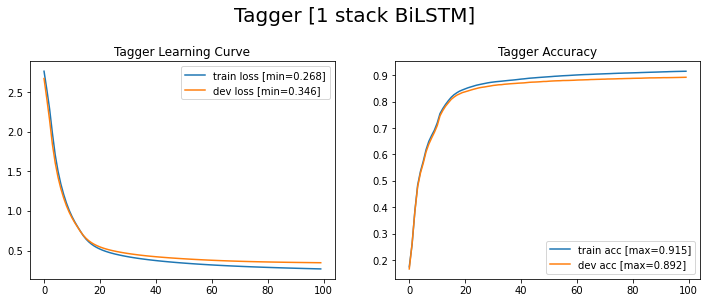

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].plot(torch.arange(len(loss_train_one_stack)), loss_train_one_stack, label=f"train loss [min={min(loss_train_one_stack):.3f}]")
axes[0].plot(torch.arange(len(loss_dev_one_stack)), loss_dev_one_stack, label=f"dev loss [min={min(loss_dev_one_stack):.3f}]")
axes[0].legend()
axes[0].set_title("Tagger Learning Curve")

axes[1].plot(torch.arange(len(acc_train_one_stack)), acc_train_one_stack, label=f"train acc [max={max(acc_train_one_stack):.3f}]")
axes[1].plot(torch.arange(len(acc_dev_one_stack)), acc_dev_one_stack, label=f"dev acc [max={max(acc_dev_one_stack):.3f}]")
axes[1].legend()
axes[1].set_title("Tagger Accuracy")

fig.suptitle(f"Tagger [{len(tagger_one_stack.lstms)} stack BiLSTM]", fontsize=20, y=1.07)

plt.show()

In [63]:
acc_test_one_stack = tagger_one_stack.compute_accuracy(en_emb_table(en_x_test), en_y_test)
acc_test_pud_one_stack = tagger_one_stack.compute_accuracy(en_emb_table(pud_x_test), pud_y_test)
acc_test_fr_one_stack = tagger_one_stack.compute_accuracy(fr_emb_table(fr_x_test), fr_y_test)

print(f'Accuracy on the english test set = {acc_test_one_stack:.3f}')
print(f'Accuracy on the english out of domain data = {acc_test_pud_one_stack:.3f}')
print(f'Accuracy on the french data = {acc_test_fr_one_stack:.3f}')

Accuracy on the english test set = 0.898
Accuracy on the english out of domain data = 0.894
Accuracy on the french data = 0.200


In [64]:
evaluation = Evaluation(tagger_one_stack, en_id_to_pos)

In [65]:
print("##### English test data #####")
evaluation.evaluate(en_emb_table(en_x_test), en_y_test)

##### English test data #####
[PROPN] precision=0.87, recall=0.76, f1=0.81
[PUNCT] precision=0.93, recall=0.96, f1=0.94
[ADJ] precision=0.88, recall=0.89, f1=0.89
[NOUN] precision=0.88, recall=0.90, f1=0.89
[VERB] precision=0.86, recall=0.89, f1=0.87
[DET] precision=0.97, recall=0.96, f1=0.96
[ADP] precision=0.92, recall=0.96, f1=0.94
[AUX] precision=0.92, recall=0.90, f1=0.91
[PRON] precision=0.94, recall=0.96, f1=0.95
[PART] precision=0.92, recall=0.90, f1=0.91
[SCONJ] precision=0.90, recall=0.71, f1=0.79
[NUM] precision=0.63, recall=0.78, f1=0.70
[ADV] precision=0.87, recall=0.86, f1=0.87
[CCONJ] precision=1.00, recall=0.99, f1=0.99
[X] precision=0.67, recall=0.10, f1=0.18
[INTJ] precision=0.94, recall=0.73, f1=0.82
[SYM] precision=0.73, recall=0.62, f1=0.67


In [68]:
print("### English out of domain data ###")
evaluation.evaluate(en_emb_table(pud_x_test), pud_y_test)

### English out of domain data ###
[PROPN] precision=0.82, recall=0.80, f1=0.81
[PUNCT] precision=0.97, recall=0.96, f1=0.97
[ADJ] precision=0.82, recall=0.89, f1=0.85
[NOUN] precision=0.91, recall=0.89, f1=0.90
[VERB] precision=0.84, recall=0.84, f1=0.84
[DET] precision=0.98, recall=0.96, f1=0.97
[ADP] precision=0.95, recall=0.97, f1=0.96
[AUX] precision=0.92, recall=0.88, f1=0.90
[PRON] precision=0.84, recall=0.92, f1=0.88
[PART] precision=0.88, recall=0.89, f1=0.88
[SCONJ] precision=0.64, recall=0.54, f1=0.59
[NUM] precision=0.72, recall=0.81, f1=0.76
[ADV] precision=0.84, recall=0.79, f1=0.82
[CCONJ] precision=0.99, recall=0.99, f1=0.99
[X] precision=nan, recall=0.00, f1=nan
[INTJ] precision=0.33, recall=1.00, f1=0.50
[SYM] precision=0.84, recall=0.64, f1=0.73


In [67]:
print("### French Data ###")
evaluation.evaluate(fr_emb_table(fr_x_test), fr_y_test)

### French Data ###
[PROPN] precision=0.20, recall=0.00, f1=0.00
[PUNCT] precision=0.39, recall=0.55, f1=0.46
[ADJ] precision=1.00, recall=0.00, f1=0.00
[NOUN] precision=0.21, recall=0.09, f1=0.13
[VERB] precision=0.40, recall=0.18, f1=0.25
[DET] precision=0.20, recall=0.20, f1=0.20
[ADP] precision=0.31, recall=0.05, f1=0.09
[AUX] precision=0.55, recall=0.29, f1=0.38
[PRON] precision=0.11, recall=0.38, f1=0.17
[PART] precision=0.00, recall=nan, f1=nan
[SCONJ] precision=0.04, recall=0.47, f1=0.07
[NUM] precision=0.14, recall=0.42, f1=0.21
[ADV] precision=nan, recall=0.00, f1=nan
[CCONJ] precision=0.27, recall=0.78, f1=0.40
[X] precision=nan, recall=0.00, f1=nan
[INTJ] precision=0.00, recall=0.00, f1=nan
[SYM] precision=0.32, recall=0.18, f1=0.23
